<a href="https://colab.research.google.com/github/ignacio-chacon/crypto_trading_ai/blob/main/baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install ta
!pip install dtreeviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import ta
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import dtreeviz
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_validate
from sklearn import tree


In [4]:
df_hist_data = pd.concat([pd.read_csv("https://github.com/ignacio-chacon/crypto_trading_ai/raw/main/hist_data_1.csv"),
                         pd.read_csv("https://github.com/ignacio-chacon/crypto_trading_ai/raw/main/hist_data_2.csv")]).reset_index().drop(columns = ["index"])

In [5]:
df_hist_data.head()

,date,open,high,low,close,Volume BTC,Volume USD
0,2017-01-01 00:00:00,966.34,966.37,966.16,966.37,15.697376,15169.245264
1,2017-01-01 00:05:00,966.43,966.58,966.43,966.58,0.438732,424.053962
2,2017-01-01 00:10:00,966.57,966.57,964.60,965.55,6.661770,6434.262218
3,2017-01-01 00:15:00,965.59,966.57,965.55,965.55,20.773385,20078.145181
4,2017-01-01 00:20:00,965.55,966.54,964.87,964.87,0.670923,647.704320


<Axes: xlabel='date', ylabel='high'>

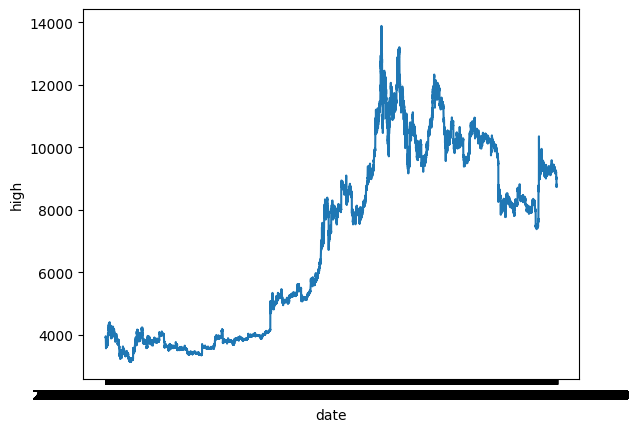

In [ ]:
sns.lineplot(x = df_hist_data["date"][200000:300000], y = df_hist_data["high"][200000:300000])

In [5]:
#no sé con que rellena el fillna, ojo con eso. Lo ideal sería que interpole, después me fijo bien.
df_hist_data_ta = ta.add_all_ta_features(df_hist_data,open="open", high="high", low="low", close="close", volume="Volume BTC", fillna = True)

/usr/local/lib/python3.9/dist-packages/ta/trend.py:780: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.9/dist-packages/ta/trend.py:785: RuntimeWarning: invalid value encountered in double_scalars


In [6]:
df_hist_data_ta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 542925 entries, 0 to 542924
Data columns (total 93 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   date                       542925 non-null  object 
 1   open                       535063 non-null  float64
 2   high                       535063 non-null  float64
 3   low                        535063 non-null  float64
 4   close                      535063 non-null  float64
 5   Volume BTC                 542925 non-null  float64
 6   Volume USD                 542925 non-null  float64
 7   volume_adi                 542925 non-null  float64
 8   volume_obv                 542925 non-null  float64
 9   volume_cmf                 542925 non-null  float64
 10  volume_fi                  542925 non-null  float64
 11  volume_em                  542925 non-null  float64
 12  volume_sma_em              542925 non-null  float64
 13  volume_vpt                 54

In [6]:
def window_input_output(data: pd.DataFrame, input_length: int, output_length: int, column: str) -> pd.DataFrame:
    
    df = data.copy()
    
    i = 1
    while i < input_length:
        df[f'x_{i}'] = df[column].shift(-i)
        i = i + 1
        
    j = 0
    while j < output_length:
        df[f'y_{j}'] = df[column].shift(-input_length-j)
        j = j + 1
        
    df = df.dropna(axis=0)
    
    return df

In [7]:
df_hist_btc_window = window_input_output(df_hist_data_ta, 5, 3, "high")
df_hist_btc_window.head()

,date,open,high,low,close,Volume BTC,Volume USD,volume_adi,volume_obv,volume_cmf,...,others_dr,others_dlr,others_cr,x_1,x_2,x_3,x_4,y_0,y_1,y_2
0,2017-01-01 00:00:00,966.34,966.37,966.16,966.37,15.697376,15169.245264,15.697376,15.697376,1.000000,...,-94.038374,0.000000,0.000000,966.58,966.57,966.57,966.54,965.26,965.24,966.40
1,2017-01-01 00:05:00,966.43,966.58,966.43,966.58,0.438732,424.053962,16.136109,16.136109,1.000000,...,0.021731,0.021728,0.021731,966.57,966.57,966.54,965.26,965.24,966.40,966.40
2,2017-01-01 00:10:00,966.57,966.57,964.60,965.55,6.661770,6434.262218,15.899396,9.474338,0.697407,...,-0.106561,-0.106618,-0.084854,966.57,966.54,965.26,965.24,966.40,966.40,966.98
3,2017-01-01 00:15:00,965.59,966.57,965.55,965.55,20.773385,20078.145181,-4.873989,30.247723,-0.111862,...,0.000000,0.000000,-0.084854,966.54,965.26,965.24,966.40,966.40,966.98,966.97
4,2017-01-01 00:20:00,965.55,966.54,964.87,964.87,0.670923,647.704320,-5.544912,29.576800,-0.125331,...,-0.070426,-0.070451,-0.155220,965.26,965.24,966.40,966.40,966.98,966.97,966.99


In [8]:
df_hist_brc_window_test_set = df_hist_btc_window[int(len(df_hist_btc_window)*0.95):]
df_hist_brc_window_train_set = df_hist_btc_window[:int(len(df_hist_btc_window)*0.95)]

In [9]:
X = df_hist_brc_window_train_set[list(df_hist_brc_window_train_set.columns)[1:-3]]
y = df_hist_brc_window_train_set[list(df_hist_brc_window_train_set.columns)[-3:]]
X_test = df_hist_brc_window_test_set[list(df_hist_brc_window_test_set.columns)[1:-3]]
y_test = df_hist_brc_window_test_set[list(df_hist_brc_window_test_set.columns)[-3:]]

## Como problema de regresión (forecasting)

In [19]:
split = TimeSeriesSplit(n_splits=10)

In [25]:
def evaluate(model, X, y, cv, scoring):
    cv_results = cross_validate(
        model,
        X,
        y,
        cv=cv,
        scoring=scoring,
    )
    acc = -cv_results["test_accuracy"]
    print(
        f"accuracy: {acc.mean():.3f} +/- {acc.std():.3f}"
    )


In [10]:
model = tree.DecisionTreeRegressor()

In [ ]:
evaluate(model, X, y, split, ["neg_root_mean_squared_error"])

Root Mean Squared Error: 2208.650 +/- 3252.475


In [13]:
model.fit(X, y)

DecisionTreeRegressor()

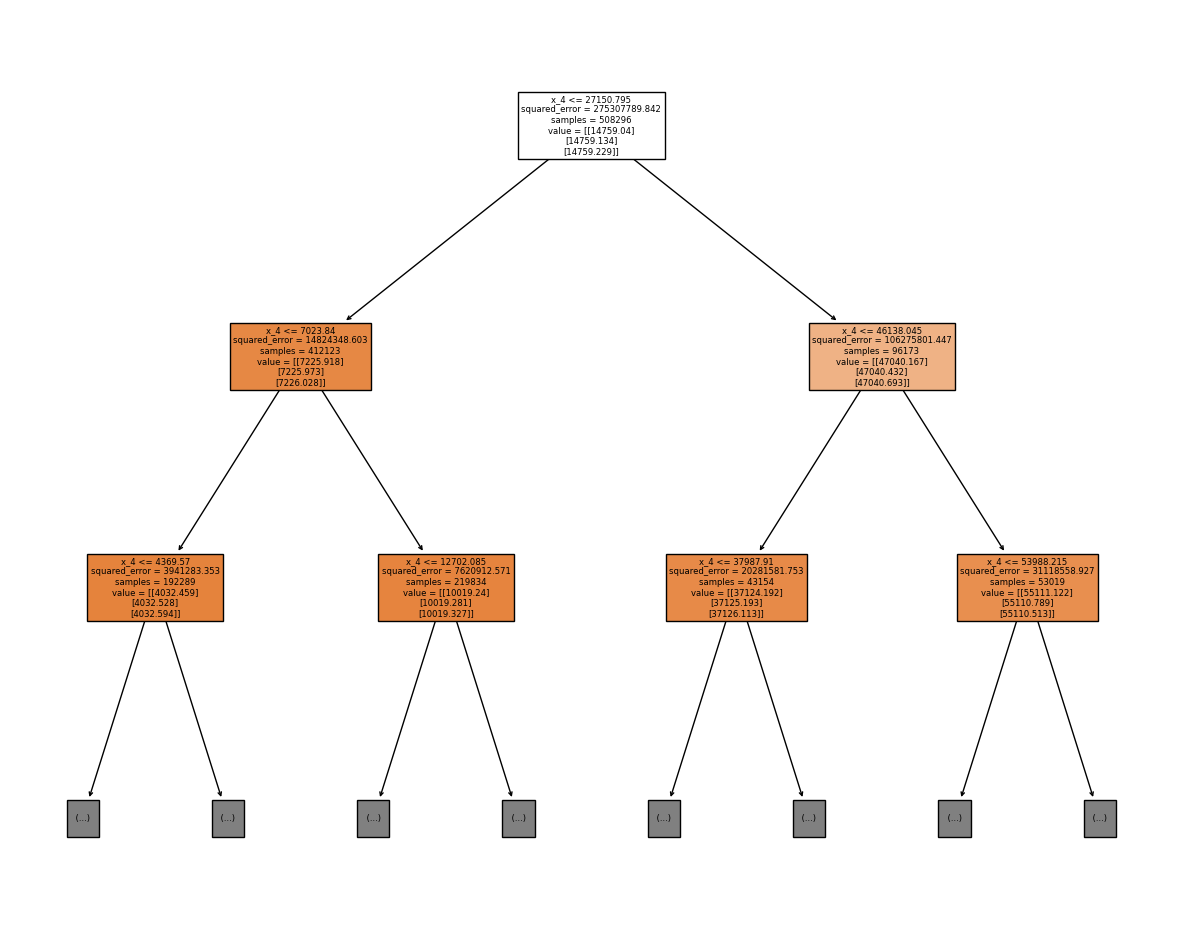

In [41]:
plt.figure(figsize=(15,12))
tree.plot_tree(model, max_depth = 2, feature_names=df_hist_brc_window_train_set.columns[1:-3], filled = True);

Vemos con claridad que el feature más importante es la anteúltima observación. Cuando tratemos el problema como uno de clasificación trataremos de ver qué tan bien predicen el resto de variables.

## Como problema de clasificación (predicción de subas, bajas y éstasis)

In [18]:
y_label_grew = y["y_2"] > X["high"]*1.001
y_label_shrunk = y["y_2"] < X["high"]*0.999
y_label = (y_label_grew + 2*y_label_shrunk)
y_label_grew_test = y_test["y_2"] > X_test["high"]*1.001
y_label_shrunk_test = y_test["y_2"] < X_test["high"]*0.999
y_label_test = (y_label_grew + 2*y_label_shrunk)

In [23]:
model = tree.DecisionTreeClassifier()

In [26]:
evaluate(model, X, y_label, split, ["accuracy"])

accuracy: -0.366 +/- 0.017


In [27]:
model.fit(X, y_label)

DecisionTreeClassifier()

In [28]:
viz_model = dtreeviz.model(model,
                           X_train=X, y_train=y_label,
                           feature_names=df_hist_brc_window_train_set.columns[1:-3],
                           target_name="labels", class_names=["stabilized", "grew", "shrank"])

In [ ]:
viz_model.view(depth_range_to_display=(1, 2))

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
